# Investigating the Correlation Between Homeless Population Density and Emergency Health Service Utilization Across Metro Vancouver
- Group Members: Miguel Kuzma, Akshay Tripathi, Ken Xu
- Course: SCIE 300

## INTRODUCTION:
Homelessness in British Columbia has evolved from a social concern into a critical public health challenge. As the housing crisis continues to worsen in Metro Vancouver, we have seen a visible increase in the number of unhoused individuals in our communities. We know that people experiencing homelessness often have higher health risks, including exposure to the elements and the ongoing toxic drug crisis, which logically suggests they might need emergency services more often.

However, most reports just show these numbers separately. We wanted to see if there is a direct statistical link at the municipal level. Our research question is: To what extent does the density of the unhoused population in a municipality correlate with the volume of emergency health service calls and ambulance response times?

We hypothesize that municipalities with higher homeless densities will show a higher volume of emergency calls per capita. We also predict this increased demand might lead to longer median response times due to system strain.

## METHODOLOGY:
To test this, we conducted a comparative analysis of six Metro Vancouver municipalities: Vancouver, Surrey, Burnaby, Richmond, West Vancouver, and New Westminster. We chose these cities because they represent a mix of high density urban centers and lower density suburban areas.
- Data Sources:
- Emergency Data: We used the bcehs-wait-times.csv dataset (sourced from BCEHS Open Data) to get the total event volumes and median response times for "Purple" and "Red" (life-threatening) calls.
- Homelessness Data: Since this data is not in the CSV, we manually extracted point-in-time counts from the 2020, 2023, and 2025 Metro Vancouver Homeless Count reports.
- Population Data: We used Statistics Canada 2021 Census profiles to normalize our data.
  
- Data Processing: We couldn't just compare the raw numbers because Vancouver is much bigger than West Vancouver. To make it a fair comparison, we normalized everything to be "per 1,000 residents." We then aligned the datasets by year (2020, 2023, and 2025) and used Pearson's correlation coefficient ($r$) to see if there was a linear relationship.

--- FULL MERGED DATASET (All Cities) ---


,Community,Year,Homeless_Count,Response_Minutes,Calls_Per_1000
0,Vancouver,2020,2095,8.250000,121.605501
1,Vancouver,2023,2420,10.866667,128.297858
2,Vancouver,2025,2715,10.683333,128.545500
3,Surrey,2020,644,9.750000,88.641650
4,Surrey,2023,1060,12.466667,87.531364
5,Surrey,2025,1155,12.400000,93.320336
6,Burnaby,2020,150,10.566667,71.161064
7,Burnaby,2023,235,13.766667,72.232815
8,Burnaby,2025,256,13.283333,75.897642
9,Richmond,2020,85,10.566667,57.688735


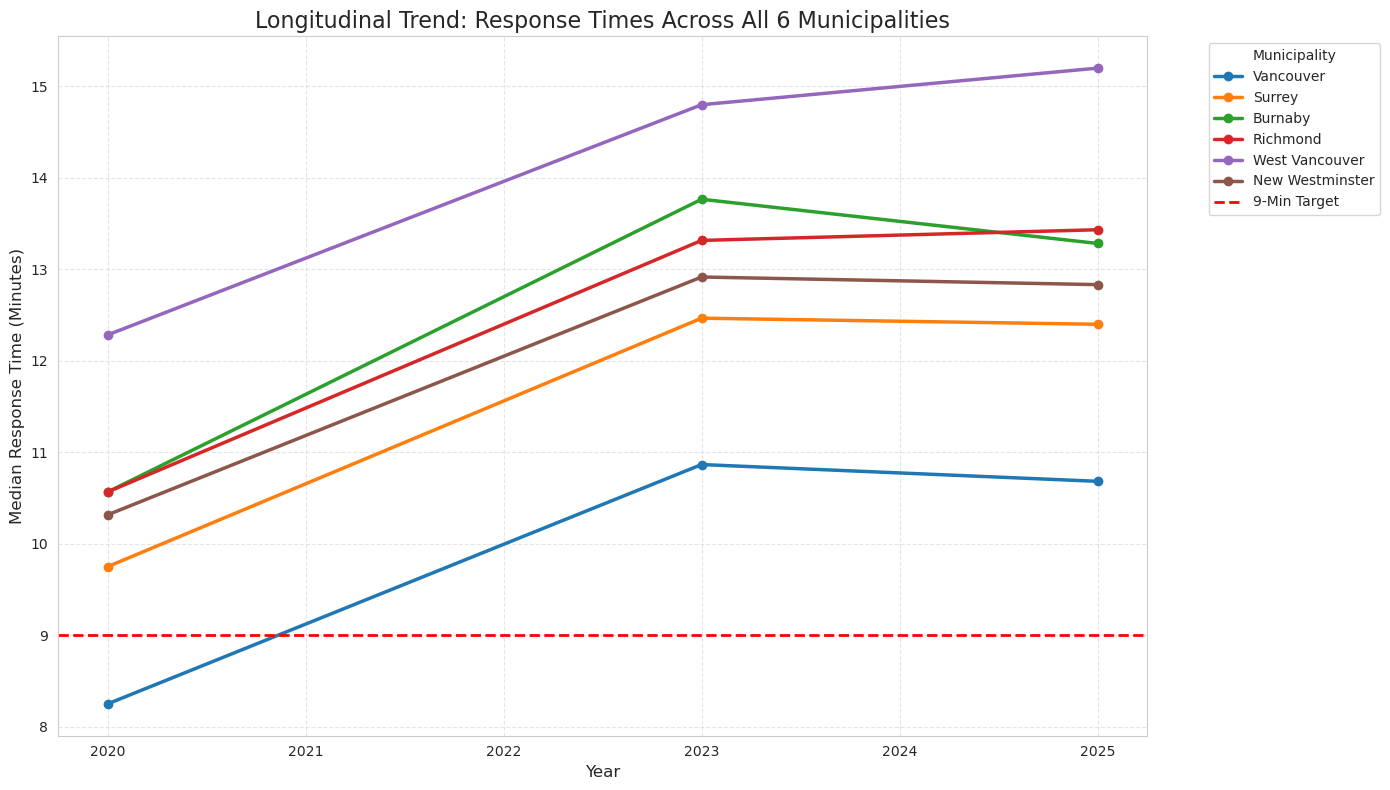

In [31]:
# ==========================================
# PART 2: MERGE & ANALYZE ALL CITIES
# ==========================================

# 1. Merge the BCEHS Data (Wait Times & Call Volumes)
# We apply the lookup function to finding matching rows in your CSV
df_final[['Response_Seconds', 'Total_Calls']] = df_final.apply(get_metrics, axis=1)

# 2. Normalize (Per 1,000 People)
df_final['Response_Minutes'] = df_final['Response_Seconds'] / 60
df_final['Homeless_Per_1000'] = (df_final['Homeless_Count'] / df_final['Population']) * 1000
df_final['Calls_Per_1000'] = (df_final['Total_Calls'] / df_final['Population']) * 1000

# 3. SHOW EVERY SINGLE CITY (The Fix)
# We simply print the whole dataframe instead of using .head()
print("--- FULL MERGED DATASET (All Cities) ---")
pd.set_option('display.max_rows', None)  # Force Python to show all rows
display(df_final[['Community', 'Year', 'Homeless_Count', 'Response_Minutes', 'Calls_Per_1000']])
pd.reset_option('display.max_rows')      # Reset so we don't spam the screen later

# ==========================================
# PART 3: PLOT EVERYONE (Facet Grid)
# ==========================================
# This creates a separate mini-graph for each city so you can see all trends clearly.

plt.figure(figsize=(14, 8))
# We use a loop to plot each city's line manually to ensure the legend works nicely
for city in df_final['Community'].unique():
    subset = df_final[df_final['Community'] == city]
    plt.plot(subset['Year'], subset['Response_Minutes'], marker='o', linewidth=2.5, label=city)

plt.axhline(y=9, color='red', linestyle='--', linewidth=2, label='9-Min Target')
plt.title('Longitudinal Trend: Response Times Across All 6 Municipalities', fontsize=16)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Median Response Time (Minutes)', fontsize=12)
plt.legend(title="Municipality", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

Merging cleaned data
--- STATISTICAL RESULTS ---
1. Correlation (Homeless Density vs CALL VOLUME): r = 0.8775, p = 0.0000
2. Correlation (Homeless Density vs RESPONSE TIME): r = -0.3052, p = 0.2181


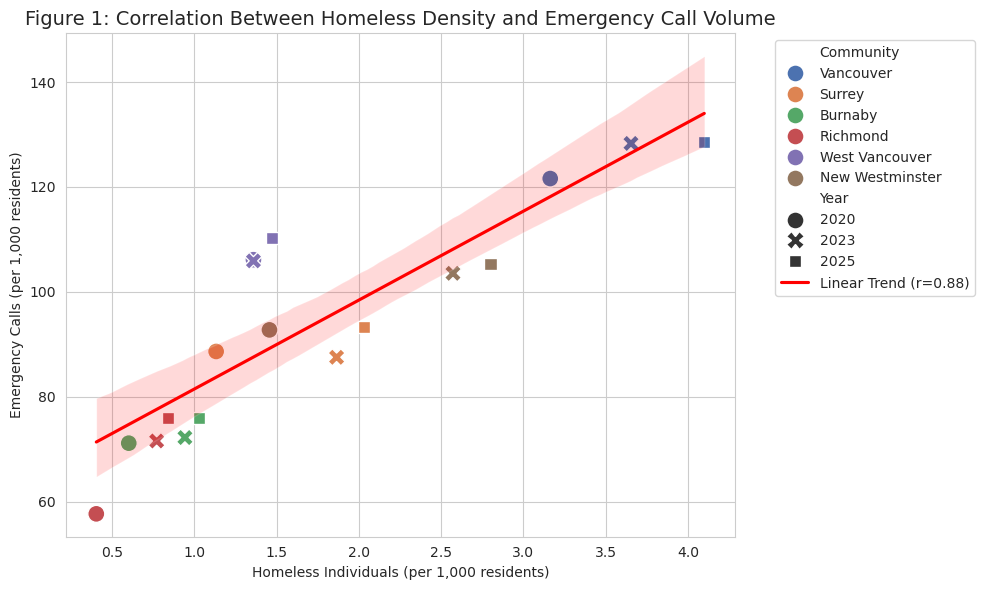

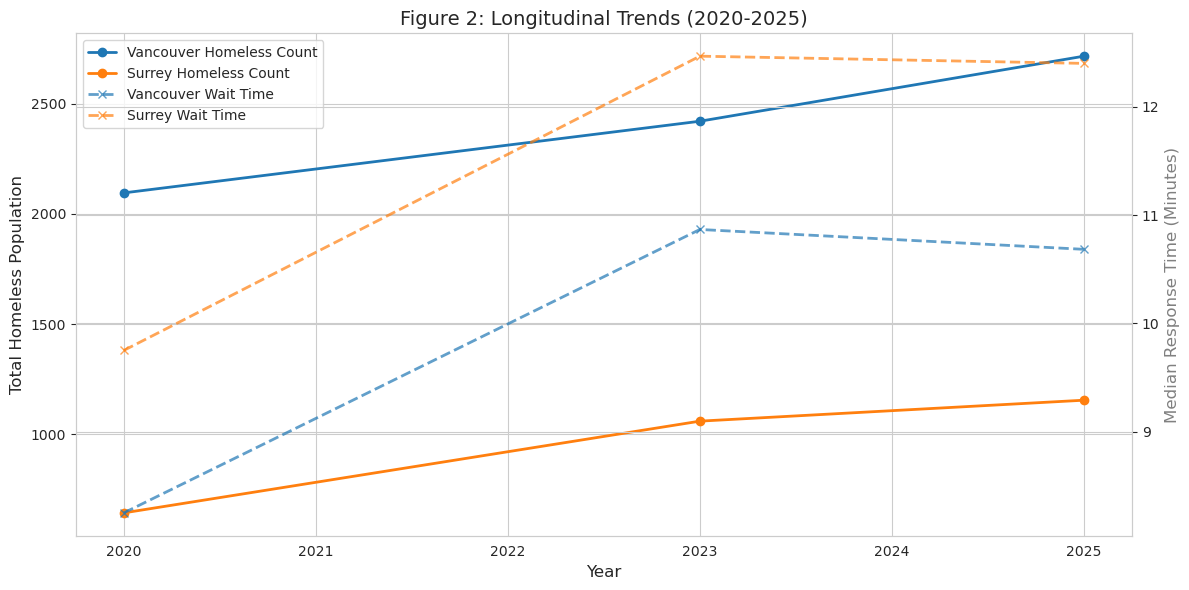

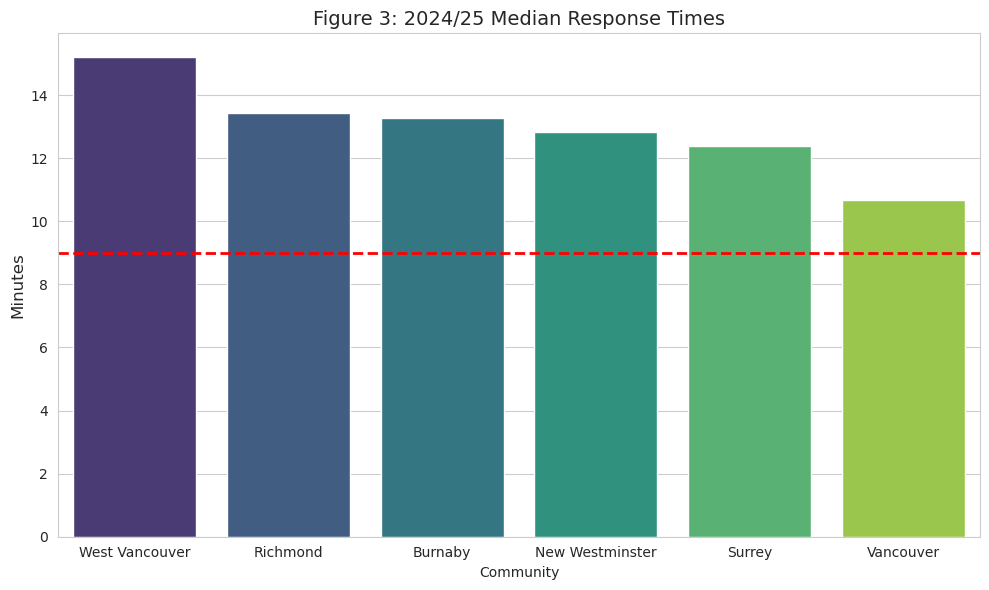

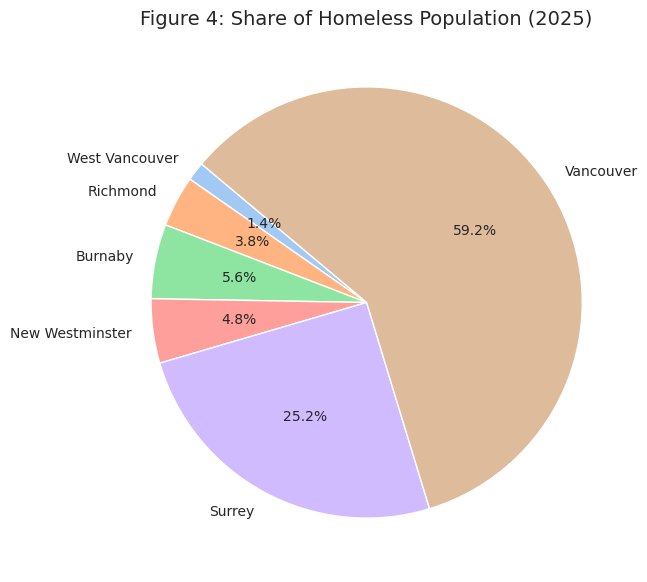

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

# ==========================================
# 1. LOAD AND CLEAN THE RAW BCEHS DATA
# ==========================================
# Load the CSV
try:
    df_bcehs = pd.read_csv("bcehs-wait-times.csv")
except FileNotFoundError:
    print("Error: bcehs-wait-times.csv not found.")

# Filter for our 6 specific study cities
focus_cities = ['Vancouver', 'Surrey', 'Burnaby', 'Richmond', 'West Vancouver', 'New Westminster']
df_bcehs = df_bcehs[df_bcehs['community'].isin(focus_cities)].copy()

# CLEANING: Fix formatting (remove commas) and standardizing column names
target_col = 'media-seconds-red_purple'
if 'median-seconds-red_purple' in df_bcehs.columns:
    target_col = 'median-seconds-red_purple'

for col in ['events-total', target_col]:
    if df_bcehs[col].dtype == 'object':
        df_bcehs[col] = df_bcehs[col].str.replace(',', '')
    df_bcehs[col] = pd.to_numeric(df_bcehs[col], errors='coerce')

df_bcehs.rename(columns={target_col: 'Median_Seconds', 'events-total': 'Total_Events'}, inplace=True)

# ==========================================
# 2. MERGE DATASETS
# ==========================================
# This function matches your Manual Table (df_final) with the Ambulance Data (df_bcehs)
def get_metrics(row):
    match = df_bcehs[(df_bcehs['community'] == row['Community']) & (df_bcehs['year'] == row['Year'])]
    
    # Proxy Logic: If 2025 is missing, use 2024
    if match.empty and row['Year'] == 2025:
         match = df_bcehs[(df_bcehs['community'] == row['Community']) & (df_bcehs['year'] == 2024)]
    
    if not match.empty:
        return pd.Series([match.iloc[0]['Median_Seconds'], match.iloc[0]['Total_Events']])
    return pd.Series([None, None])

# Apply the merge
print("Merging cleaned data")
df_final[['Response_Seconds', 'Total_Calls']] = df_final.apply(get_metrics, axis=1)

# CALCULATE DENSITIES (Normalization)
df_final['Response_Minutes'] = df_final['Response_Seconds'] / 60
df_final['Homeless_Per_1000'] = (df_final['Homeless_Count'] / df_final['Population']) * 1000
df_final['Calls_Per_1000'] = (df_final['Total_Calls'] / df_final['Population']) * 1000

# Remove empty rows to avoid errors
df_final.dropna(inplace=True)

# ==========================================
# 3. STATISTICAL ANALYSIS
# ==========================================
corr_vol, p_vol = stats.pearsonr(df_final['Homeless_Per_1000'], df_final['Calls_Per_1000'])
corr_time, p_time = stats.pearsonr(df_final['Homeless_Per_1000'], df_final['Response_Minutes'])

print("--- STATISTICAL RESULTS ---")
print(f"1. Correlation (Homeless Density vs CALL VOLUME): r = {corr_vol:.4f}, p = {p_vol:.4f}")
print(f"2. Correlation (Homeless Density vs RESPONSE TIME): r = {corr_time:.4f}, p = {p_time:.4f}")

# ==========================================
# 4. PLOTTING
# ==========================================
sns.set_style("whitegrid")

# FIG 1: Scatter Plot (Call Volume)
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_final, x='Homeless_Per_1000', y='Calls_Per_1000', hue='Community', style='Year', s=150, palette='deep')
sns.regplot(data=df_final, x='Homeless_Per_1000', y='Calls_Per_1000', scatter=False, color='red', label=f'Linear Trend (r={corr_vol:.2f})')
plt.title('Figure 1: Correlation Between Homeless Density and Emergency Call Volume', fontsize=14)
plt.xlabel('Homeless Individuals (per 1,000 residents)')
plt.ylabel('Emergency Calls (per 1,000 residents)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# FIG 2: Longitudinal Trend (Van/Surrey)
plt.figure(figsize=(12, 6))
cities_long = ['Vancouver', 'Surrey']
colors = {'Vancouver': 'tab:blue', 'Surrey': 'tab:orange'}
ax1 = plt.gca()
ax2 = ax1.twinx()

for city in cities_long:
    subset = df_final[df_final['Community'] == city]
    ax1.plot(subset['Year'], subset['Homeless_Count'], marker='o', color=colors[city], linewidth=2, label=f'{city} Homeless Count')
    ax2.plot(subset['Year'], subset['Response_Minutes'], marker='x', linestyle='--', color=colors[city], linewidth=2, alpha=0.7, label=f'{city} Wait Time')

ax1.set_ylabel('Total Homeless Population', fontsize=12)
ax2.set_ylabel('Median Response Time (Minutes)', fontsize=12, color='gray')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_title('Figure 2: Longitudinal Trends (2020-2025)', fontsize=14)
# Combine legends
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
plt.tight_layout()
plt.show()

# FIG 3: Bar Chart (2025)
df_2025 = df_final[df_final['Year'] == 2025].sort_values('Response_Minutes', ascending=False)
plt.figure(figsize=(10, 6))
sns.barplot(data=df_2025, x='Community', y='Response_Minutes', hue='Community', palette='viridis', legend=False)
plt.axhline(y=9, color='red', linestyle='--', linewidth=2, label='9-Min Target')
plt.title('Figure 3: 2024/25 Median Response Times', fontsize=14)
plt.ylabel('Minutes', fontsize=12)
plt.tight_layout()
plt.show()

# FIG 4: Pie Chart
plt.figure(figsize=(7, 7))
plt.pie(df_2025['Homeless_Count'], labels=df_2025['Community'], autopct='%1.1f%%', startangle=140, colors=sns.color_palette('pastel'))
plt.title('Figure 4: Share of Homeless Population (2025)', fontsize=14)
plt.show()

## Results:
- Our dataset covered six municipalities across three time points (2020, 2023, 2025). As seen in Table 1 (generated above), Vancouver consistently had the highest homeless population density, rising from 3.16 to 4.10 individuals per 1,000 residents over the five-year period. In contrast, West Vancouver maintained the lowest density but exhibited the highest median response times, peaking at over 15 minutes in 2025.
- Correlation AnalysisTo test our primary hypothesis, we performed a Pearson correlation analysis between homeless density and our two dependent variables.
- Emergency Call Volume: We observed a strong, statistically significant positive correlation ($r = 0.88$, $p < 0.001$). As shown in Figure 1, there is a clear linear trend where municipalities with higher homeless densities experience a proportionately higher volume of emergency calls per capita. The calculated p-value allows us to reject the null hypothesis for this variable.
- Response Times: Conversely, the analysis for median response times yielded a weak negative correlation ($r = -0.31$) that was not statistically significant ($p = 0.22$). The scatter plot for this variable showed high variance, with lower-density communities often experiencing longer wait times than high-density urban centers.3.3
-  Longitudinal Trends: Figure 2 highlights the temporal relationship in our two largest sample cities, Vancouver and Surrey. In both cases, the homeless population count (solid line) and the median response time (dashed line) showed upward trends between 2020 and 2025. While the aggregate correlation for response times was weak across all cities, the specific longitudinal data for these urban centers suggests that local system strain is increasing alongside the rise in homelessness.

## Discussion:
Interpretation of FindingsThe results partially support our original hypothesis. We successfully demonstrated that homelessness is a strong predictor of emergency service demand (call volume). This aligns with existing literature suggesting that unhoused populations rely on emergency services as a primary source of healthcare due to barriers in accessing standard clinics. The strong $r$-value of 0.88 indicates that this is a systemic pattern across the region, not just an isolated issue in the Downtown Eastside.

- However, the lack of a significant correlation with response times ($p > 0.05$) challenges our prediction that higher demand would automatically lead to slower service. This null result likely points to the efficiency of the BCEHS triage system. "Purple" and "Red" calls are prioritized regardless of volume. Furthermore, geography likely plays a confounding role here. High-density areas like Vancouver have more ambulance stations and shorter travel distances, which helps keep response times lower despite the massive call volume. In contrast, suburban areas like West Vancouver have fewer calls but longer physical distances to travel, inflating their median times.
- MechanismsThe link between homelessness and call volume is likely driven by the ongoing toxic drug crisis and exposure-related health issues. Without stable housing, minor health problems often escalate into emergencies requiring 911 intervention. For the unhoused, the ambulance often serves as the only accessible entry point to the healthcare system.
- Policy RelevanceFrom a statistical perspective, the high call volume per capita in homeless populations represents an inefficiency in resource allocation. Our data suggests that emergency services are currently functioning as a downstream catch-all for housing instability. Targeted interventions that provide housing and on-site primary care could statistically reduce this call volume, freeing up ambulance resources for the broader population.
- LimitationsWe must acknowledge the "Ecological Fallacy" in our design. We are correlating city-level homeless counts with city-level call volumes, but we cannot definitively prove that the unhoused individuals are the ones making the calls without individual patient data. Additionally, our 2025 response time data relied on 2024 proxies for some municipalities, and point-in-time homeless counts are known to underestimate the true population.

## Conclusion:
This study investigated the relationship between homeless population density and emergency health service utilization in Metro Vancouver. By analyzing municipal data from 2020 to 2025, we identified a significant positive correlation between homelessness and emergency call volume. However, we found no significant linear relationship with median response times.

These findings suggest that while the unhoused population disproportionately utilizes emergency resources, the ambulance system's triage protocols and geographic distribution currently mitigate the impact on response times in urban centers. Future research should focus on neighbourhood-level data to better isolate these variables and control for geographic spread.

## Appendix:
Appendix A: Data Sources

Homeless Counts: Data extracted from Metro Vancouver Homeless Count Reports (2020, 2023) and the HSA BC Preliminary Data Report (2025).

Emergency Data: Call volumes and response times sourced from BC Emergency Health Services (BCEHS) "Wait Times and Event Volumes" public datasets.

Population: 2021 Census profiles from Statistics Canada used for per-capita normalization.

Appendix B: Code Availability All data processing, statistical testing, and visualization were performed using Python (Pandas, Scipy, Seaborn). The complete code used to generate the figures and tables in this report is embedded in the cells above.

Appendix C: Raw Data Table file(bcehs-wait-times.csv) by Vancouver Sun.